# Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39137")

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import s3fs
import numpy as np
import xarray as xr
import scipy
import dask
import gsw
import matplotlib.pyplot as plt
import eos_module, filter_module
import xesmf as xe
import xgcm

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read and prepare Xarray data

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [6]:
data=[dict() for i in range(6)]
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-75))})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-75))})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-75))})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-75))})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490))})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490))})

In [7]:
time_slice = dict(time_counter=slice(0,-1,150)) # take every 150-th time output
nb_of_time_chunks = 4   # number of chunks on time-axis

## Read

In [8]:
%%time
for i in range(len(data)) :
    data[i]['HR'] = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask()\
    .drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')\
    .isel(time_slice | data[i]['xy_slice']).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    #.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    #current_set['x'] = np.arange(len(current_set['x']))
    #current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 993 ms, sys: 71.6 ms, total: 1.06 s
Wall time: 3.62 s


CPU times: user 542 ms, sys: 34.5 ms, total: 576 ms
Wall time: 7.43 s


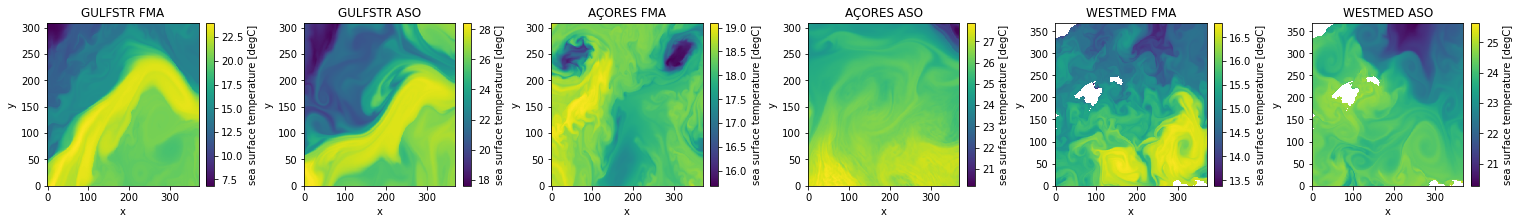

In [310]:
%%time
fig, ax = plt.subplots(ncols=len(data), nrows=1, figsize=(3.5*len(data),3), constrained_layout=True)
for i in range(len(data)) :
    #data[i]['HR'].isel(time_counter=0)['sosstsst'].fillna(data[i]['HR'].isel(time_counter=0)['sosstsst'].mean()).plot(ax=ax[i])
    data[i]['HR'].isel(time_counter=0)['sosstsst'].plot(ax=ax[i])
    ax[i].set(title=data[i]['label'])

In [10]:
list(data[i]['HR'].var())

['sosaline', 'sosstsst', 'tmask']

## Compute true density

In [11]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized')
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 68.2 ms, sys: 2.06 ms, total: 70.3 ms
Wall time: 68.5 ms


# Coarse graining

In [12]:
metrics_HR = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('X', 'Y',): ['area_t', 'area_u', 'area_v', 'area_f'] # Areas 
}

In [13]:
metrics_LR = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}

In [14]:
# taken from xgcm tutorial https://xgcm.readthedocs.io/en/latest/xgcm-examples/05_autogenerate.html?highlight=distance#Periodic-2D-example
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [15]:
eORCA025_global_mesh = xr.open_dataset('../global_eORCA025_mesh.nc')

In [111]:
eORCA025_global_mesh

<xarray.Dataset>
Dimensions:  (x: 1440, y: 1205, x_b: 1441, y_b: 1206)
Coordinates:
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lat      (y, x) float64 -84.17 -84.17 -84.17 -84.17 ... 50.07 50.02 50.0
    lon      (y, x) float64 73.0 73.25 73.5 73.75 74.0 ... 73.0 73.0 73.0 73.0
    lon_b    (y_b, x_b) float64 72.88 73.12 73.37 73.62 ... 73.0 73.0 73.0 73.0
    lat_b    (y_b, x_b) float64 -84.19 -84.19 -84.19 -84.19 ... 50.04 50.01 50.0
    e1t      (y, x) float64 ...
    e2t      (y, x) float64 ...
    mask     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    *empty*

In [311]:
def coarsen(XdataSet) :
    # prepare input dataset for coarseinig
    input_ds = XdataSet
    # generate corner lat lon
    input_ds = xgcm.autogenerate.generate_grid_ds(input_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    input_ds = xgcm.autogenerate.generate_grid_ds(input_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    # adjust names of coords for regridder
    input_ds = input_ds.rename({'x_outer': 'x_b','y_outer': 'y_b', 'x_right' : 'x_r', 'y_right' : 'y_r'})
    input_ds.coords['mask'] = input_ds['tmask']
    input_ds.coords['area_t'] = input_ds['e1t']*input_ds['e2t']
    input_ds.coords['area_u'] = input_ds['e1u']*input_ds['e2u']
    input_ds.coords['area_v'] = input_ds['e1v']*input_ds['e2v']
    input_ds.coords['area_f'] = input_ds['e1f']*input_ds['e2f']
    xgcm_grid_HR = xgcm.Grid(input_ds, metrics=metrics_HR, periodic=False, coords={'X' : {'center' : 'x', 'outer' : 'x_b', 'right' : 'x_r'}, \
                                           'Y' : {'center' : 'y', 'outer' : 'y_b', 'right' : 'y_r'}})
    input_ds.coords['lon_b'] = xgcm_grid_HR.interp(da=input_ds['lon_outer'], axis='Y', to='outer')
    input_ds.coords['lat_b'] = xgcm_grid_HR.interp(da=input_ds['lat_outer'], axis='X', to='outer')
    
    # prepare output grid
    grid_LR = eORCA025_global_mesh # - quarter degree global grid
    # to take a part of the global grid corresponding to the data cut
    selection = grid_LR.lon.where((grid_LR.lon>=input_ds.lon.min().values) & (grid_LR.lon<=input_ds.lon.max().values) &\
                                  (grid_LR.lat>=input_ds.lat.min().values) & (grid_LR.lat<=input_ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    #selected_x_b = [ (element - 0.5) for element in range(selected_x[0], selected_x[-1]+2)]
    #selected_y_b = [ (element - 0.5) for element in range(selected_y[0], selected_y[-1]+2)]
    grid_LR = grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y)
    # reinit x and y arrays
    grid_LR.coords['x'] = np.arange(1,len(selected_x))
    grid_LR.coords['y'] = np.arange(1,len(selected_y))
    grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5
    grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder_with_mask = xe.Regridder(input_ds, grid_LR, method="conservative_normed")
    # perform regridding
    coarsened_ds = regridder_with_mask(input_ds).drop(['x_b', 'y_b', 'x_r', 'y_r', 'lon_b', 'lat_b'])
    coarsened_ds.coords['mask'] = grid_LR['mask']
    coarsened_ds.coords['e1t'] = grid_LR['e1t']
    coarsened_ds.coords['e2t'] = grid_LR['e2t']
    coarsened_ds.coords['area_t'] = coarsened_ds.coords['e1t']*coarsened_ds.coords['e2t']
    coarsened_ds = xgcm.autogenerate.generate_grid_ds(coarsened_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    
    return coarsened_ds

In [312]:
%%timeit
for i in range(len(data)) :
    data[i]['LR'] = coarsen(data[i]['HR'])

25.4 s ± 466 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CPU times: user 411 ms, sys: 18.6 ms, total: 429 ms
Wall time: 8.21 s


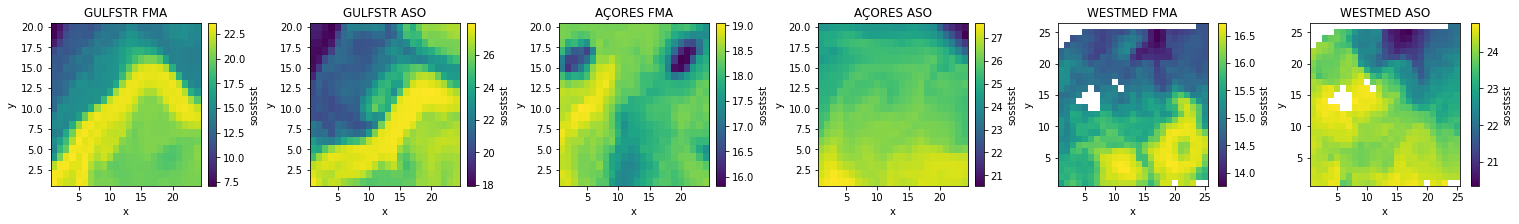

In [313]:
%%time
fig, ax = plt.subplots(ncols=len(data), nrows=1, figsize=(3.5*len(data),3), constrained_layout=True)
for i in range(len(data)) :
    #data[i]['HR'].isel(time_counter=0)['sosstsst'].fillna(data[i]['HR'].isel(time_counter=0)['sosstsst'].mean()).plot(ax=ax[i])
    data[i]['LR'].isel(time_counter=0)['sosstsst'].plot(ax=ax[i])
    ax[i].set(title=data[i]['label'])

In [315]:
data[4]['LR']

<xarray.Dataset>
Dimensions:        (time_counter: 15, y: 26, x: 25, x_right: 25, y_right: 26)
Coordinates:
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
    lon            (y, x) float64 1.612 1.863 2.113 2.364 ... 7.349 7.601 7.852
    lat            (y, x) float64 37.11 37.1 37.1 37.09 ... 41.56 41.55 41.54
  * x              (x) int64 1 2 3 4 5 6 7 8 9 10 ... 17 18 19 20 21 22 23 24 25
  * y              (y) int64 1 2 3 4 5 6 7 8 9 10 ... 18 19 20 21 22 23 24 25 26
    e1t            (y, x) float64 2.224e+04 2.224e+04 ... 2.095e+04 2.095e+04
    e2t            (y, x) float64 2.15e+04 2.148e+04 ... 1.943e+04 1.941e+04
    mask           (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    area_t         (y, x) float64 4.781e+08 4.778e+08 ... 4.07e+08 4.065e+08
  * x_right        (x_right) float64 1.5 2.5 3.5 4.5 5.5 ... 22.5 23.5 24.5 25.5
  * y_right        (y_right) float64 1.5 2.5 3.5 4.5 5.5 ... 23.5 24.5 25.5 26.5
Data variables:
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(4, 26, 25), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(4, 26, 25), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(26, 25), meta=np.ndarray>
    sigma0_true    (time_counter, y, x) float64 dask.array<chunksize=(4, 26, 25), meta=np.ndarray>
    sst_sqr        (time_counter, y, x) float32 dask.array<chunksize=(4, 26, 25), meta=np.ndarray>
    sal_sqr        (time_counter, y, x) float32 dask.array<chunksize=(4, 26, 25), meta=np.ndarray>
Attributes:
    regrid_method:  conservative_normed

In [318]:
data[4]['LR'].var()

<xarray.Dataset>
Dimensions:      ()
Data variables:
    sosaline     float32 dask.array<chunksize=(), meta=np.ndarray>
    sosstsst     float32 dask.array<chunksize=(), meta=np.ndarray>
    tmask        float64 dask.array<chunksize=(), meta=np.ndarray>
    sigma0_true  float64 dask.array<chunksize=(), meta=np.ndarray>
    sst_sqr      float32 dask.array<chunksize=(), meta=np.ndarray>
    sal_sqr      float32 dask.array<chunksize=(), meta=np.ndarray>

2022-09-28 15:41:10,231 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
